In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

from utils.matrix_factor_utils import mask_datasets, loss_function, recall_at_k, precision_at_k
from models.matrix_factorization import MatrixFactorization
from utils.data_utils import build_user_item_interactions, get_positive_negative_ratings

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
from utils.preprocess import load_dataset

# Load the dataset
dataset = 'movielens-1m'
users, items, train_ratings, test_ratings, items_features_tensor, user_features_tensor = load_dataset(dataset)

/home/jvthunder/anaconda/envs/rec-sys/lib/python3.9/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [4]:
rating_matrix_train, mask_matrix_train, \
rating_matrix_val, mask_matrix_val, \
rating_matrix_test, mask_matrix_test = mask_datasets(device, train_ratings, test_ratings, val_ratio=0.1)

In [5]:
positive_threshold = 5
negative_threshold = 4

train_user_item_dict = build_user_item_interactions(train_ratings)
test_user_item_dict = build_user_item_interactions(test_ratings)
train_user_ratings = get_positive_negative_ratings(train_user_item_dict, positive_threshold, negative_threshold)
test_user_ratings = get_positive_negative_ratings(test_user_item_dict, positive_threshold, negative_threshold)

In [6]:
latent_dim = 64      # Number of latent factors
alpha = 0.01         # Regularization parameter for user factors
beta = 0.01          # Regularization parameter for item factors
num_epochs = 500     # Number of training epochs
learning_rate = 0.001
k = 10

In [7]:
# Initialize the model
num_users, num_items = rating_matrix_train.shape

model = MatrixFactorization(num_users, num_items, latent_dim, rating_matrix_train).to(device)
early_stop = 0
best_val_rmse = float('inf')

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# save for plots
train_losses = []
recalls = []
precisions = []

# Training loop
for epoch in range(1, num_epochs + 1):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    pred_ratings = model()
    
    # Compute loss
    loss = loss_function(pred_ratings, rating_matrix_train, mask_matrix_train, model, alpha, beta)
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    
    # Compute RMSE on observed ratings
    with torch.no_grad():
        train_mse = ((mask_matrix_train * (rating_matrix_train - pred_ratings)) ** 2).sum() / mask_matrix_train.sum()
        train_rmse = torch.sqrt(train_mse)

        val_mse = ((mask_matrix_val * (rating_matrix_val - pred_ratings)) ** 2).sum() / mask_matrix_val.sum()
        val_rmse = torch.sqrt(val_mse)

        test_mse = ((mask_matrix_test * (rating_matrix_test - pred_ratings)) ** 2).sum() / mask_matrix_test.sum()
        test_rmse = torch.sqrt(test_mse)

    # Early stopping
    if val_rmse < best_val_rmse:
        best_val_rmse = val_rmse
        early_stop = 0
    else:
        early_stop += 1
        if early_stop == 10:
            print(f'Converged at epoch {epoch}')
            break
    
    train_losses.append(loss.item())
    # Print progress
    if epoch % 10 == 0:
        recall = recall_at_k(train_user_ratings, model.embeddings, k=10)
        precision = precision_at_k(train_user_ratings, model.embeddings, k=10)
        recalls.append(recall)
        precisions.append(precision)
        print(f'Epoch [{epoch}/{num_epochs}], Train Loss: {loss.item():.4f}, Train RMSE: {train_rmse.item():.4f}, Val RMSE: {val_rmse.item():.4f}, Test RMSE: {test_rmse.item():.4f}')
        print(f'Recall@{k}: {recall:.4f}, Precision@{k}: {precision:.4f}')

Epoch [10/500], Train Loss: 997875.3803, Train RMSE: 1.1098, Val RMSE: 1.1103, Test RMSE: 1.1125
Recall@10: 0.2945, Precision@10: 0.5725
Epoch [20/500], Train Loss: 979648.2134, Train RMSE: 1.0996, Val RMSE: 1.1012, Test RMSE: 1.1034
Recall@10: 0.3237, Precision@10: 0.6265
Epoch [30/500], Train Loss: 953258.2329, Train RMSE: 1.0847, Val RMSE: 1.0876, Test RMSE: 1.0897
Recall@10: 0.3227, Precision@10: 0.6249
Epoch [40/500], Train Loss: 916355.4907, Train RMSE: 1.0635, Val RMSE: 1.0679, Test RMSE: 1.0700
Recall@10: 0.3152, Precision@10: 0.6126
Epoch [50/500], Train Loss: 869883.8204, Train RMSE: 1.0362, Val RMSE: 1.0424, Test RMSE: 1.0444
Recall@10: 0.3080, Precision@10: 0.6023
Epoch [60/500], Train Loss: 818339.3914, Train RMSE: 1.0050, Val RMSE: 1.0135, Test RMSE: 1.0155
Recall@10: 0.3034, Precision@10: 0.5965
Epoch [70/500], Train Loss: 767952.8815, Train RMSE: 0.9736, Val RMSE: 0.9847, Test RMSE: 0.9867
Recall@10: 0.3008, Precision@10: 0.5958
Epoch [80/500], Train Loss: 723600.3410, 

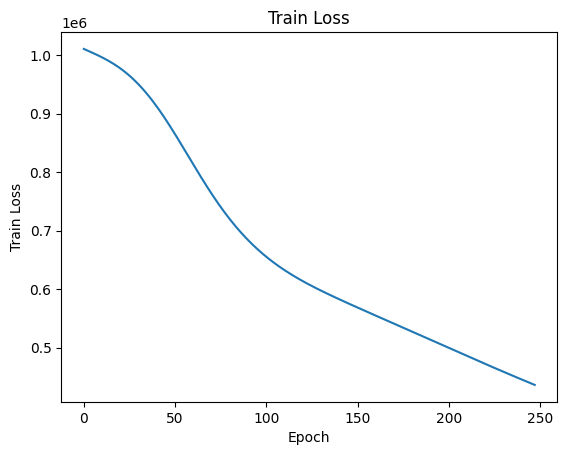

In [8]:
# make plots
import matplotlib.pyplot as plt

plt.plot(train_losses)
plt.xlabel('Epoch') 
plt.ylabel('Train Loss')
plt.title('Train Loss')
plt.show()

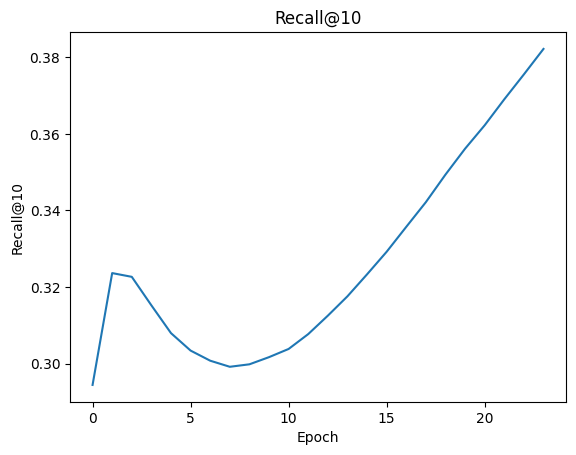

In [9]:
# Recall
plt.plot(recalls)
plt.xlabel('Epoch')
plt.ylabel('Recall@10')
plt.title('Recall@10')
plt.show()

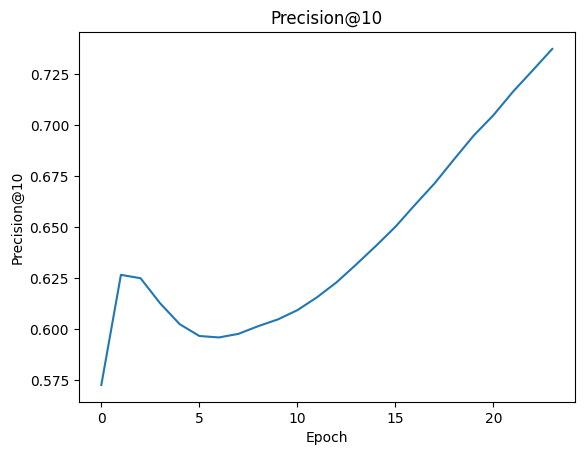

In [10]:
# Precision
plt.plot(precisions)
plt.xlabel('Epoch')
plt.ylabel('Precision@10')
plt.title('Precision@10')
plt.show()

In [11]:
recall = recall_at_k(test_user_ratings, model.embeddings, k=10)
precision = precision_at_k(test_user_ratings, model.embeddings, k=10)

print(f'Test Recall@{k}: {recall:.4f}, Test Precision@{k}: {precision:.4f}')

Test Recall@10: 0.5128, Test Precision@10: 0.5317
